In [20]:
import os
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [21]:
google_apps = pd.read_csv("googleplaystore.csv")
google_apps.shape

(10841, 13)

In [22]:
google_apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,07-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,01-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,08-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [23]:
google_apps['Rating'].fillna((google_apps['Rating'].mean()), inplace=True)

In [24]:
#DATA CLEANING

#total number of unique apps in dataset
no_of_apps = google_apps["App"].nunique()
print(f"Number of unique apps: {no_of_apps}")

#remove all duplicate rows corresponding to app column
google_apps.drop_duplicates(subset=['App'], keep=False)
google_apps

#delete unnecesaary rows creating issues in modelling
google_apps = google_apps.drop([10472])

#conversion of size column to a convinient format
google_apps["Size"] = google_apps["Size"].apply(lambda x: str(x).replace(",", "") if "," in str(x) else x)
google_apps["Size"] = google_apps["Size"].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
google_apps["Size"] = google_apps["Size"].apply(lambda x: str(x).replace("Varies with device", "NAN") if "Varies with device" in str(x) else x)
google_apps["Size"] = google_apps["Size"].apply(lambda x: float(str(x).replace('k', '')) / 1024 if 'k' in str(x) else x)
google_apps["Size"] = google_apps["Size"].apply(lambda x:x.replace("+","")if "+" in str(x) else x)

#convert size to float and replace 'NAN' in size column with mean of the column
google_apps["Size"] = google_apps["Size"].apply(lambda x:float(x))
google_apps["Size"].fillna((google_apps["Size"].mean()), inplace=True)


#Install column with '+', ',' signs are removed to help easy computation
google_apps["Installs"] = google_apps["Installs"].apply(lambda x:x.replace("+","")if "+" in str(x) else x)
google_apps["Installs"] = google_apps["Installs"].apply(lambda x: x.replace(",","") if "," in str(x) else x)
google_apps["Installs"] = google_apps["Installs"].apply(lambda x:float(x))


#Converting Type column to 1 (for paid) and 0 (for free) apps
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1
google_apps['Type'] = google_apps['Type'].map(type_cat)
    
google_apps["Reviews"] = google_apps["Reviews"].astype("int64")
    
#Make the price column consistent by removing the '$' symbol and replacing "Free" with 0
google_apps["Price"] = google_apps["Price"].apply(lambda x: x.replace("Free",0) if "Free" in str(x) else x)
google_apps["Price"] = google_apps["Price"].apply(lambda x:x.replace("$","") if "$" in str(x)else x)
google_apps["Price"] = google_apps["Price"].apply(lambda x: float(x))
google_apps["Price"].dtype

Number of unique apps: 9660


dtype('float64')

In [25]:
google_apps['Category_C'] = google_apps['Category']

In [26]:
google_apps_copy = google_apps.copy()
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in columns and converting the type
google_apps_copy['Category'] = label_encoder.fit_transform(google_apps_copy['Category']) 
google_apps_copy['Content Rating'] = label_encoder.fit_transform(google_apps_copy['Content Rating']) 
google_apps_copy['Genres'] = label_encoder.fit_transform(google_apps_copy['Genres']) 
google_apps_copy.dtypes

App                object
Category            int32
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type                int64
Price             float64
Content Rating      int32
Genres              int32
Last Updated       object
Current Ver        object
Android Ver        object
Category_C         object
dtype: object

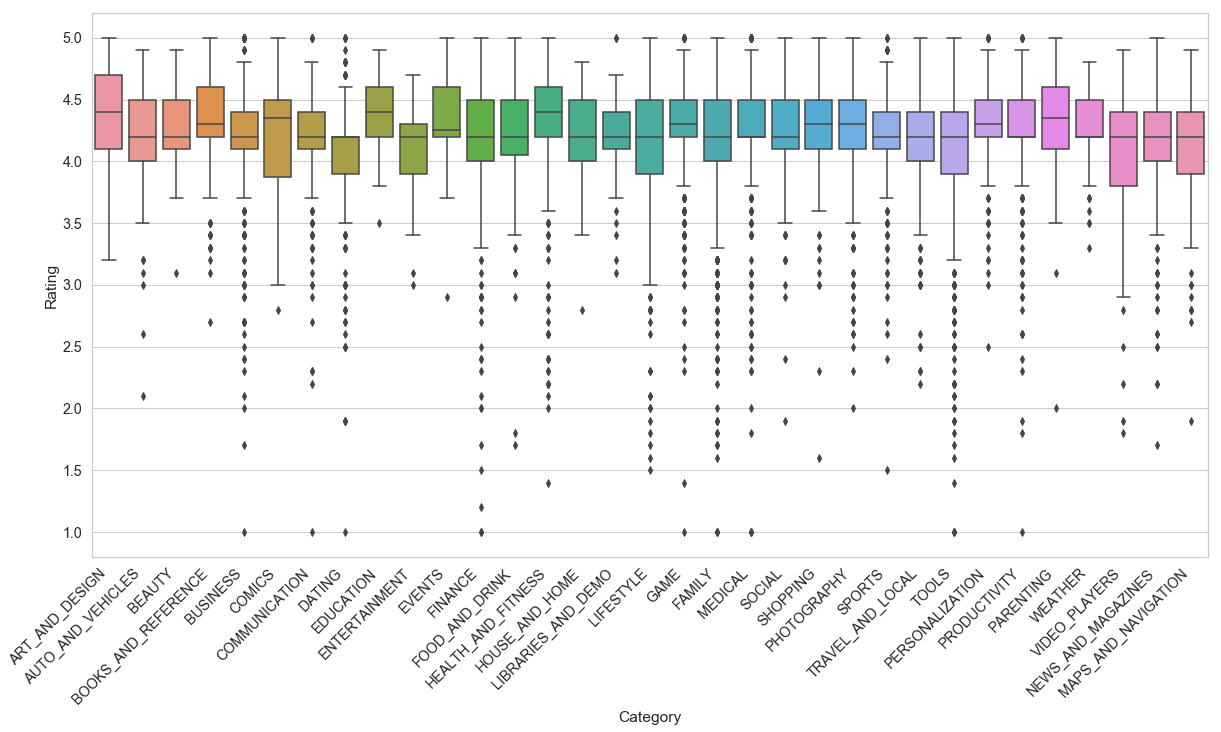

In [27]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.3, style='whitegrid')
ax = sns.boxplot(x="Category",y="Rating",data=google_apps)
labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,ha='right')

In [28]:
google_apps_copy = google_apps_copy.drop(["App","Last Updated","Current Ver","Android Ver"],axis=1)

In [29]:
google_apps_copy.to_csv("result_play_store.csv", encoding='utf-8', index=False)

In [30]:
print("There are {} total rows.".format(google_apps_copy.shape[0]))
count_popular = google_apps_copy[google_apps_copy["Installs"] > 100000].count()

print("{} have High Install popularity !".format(count_popular[0]))
print("{} have Low Install popularity !\n".format((google_apps_copy.shape[0]-count_popular)[0]))

#print("For an 80-20 training/test split, we need about {} apps for testing\n".format(google_apps_copy.shape[0]*.20))

google_apps_copy["Installs"] = (google_apps_copy["Installs"] > 100000)*1 #Installs Binarized

#print("Cut {} apps off Popular ones for a total of 3558 Popular training apps.".format(int(4568*.22132)))
#print("Cut {} apps off Unpopular ones for a total of 3558 Unpopular training apps.\n".format(int(4324*.17738)))

There are 10840 total rows.
4950 have High Install popularity !
5890 have Low Install popularity !



In [31]:
testing_popular1 = google_apps_copy[google_apps_copy["Installs"] == 1].sample(1010,random_state=0)
google_apps_copy = google_apps_copy.drop(testing_popular1.index)
#print("Values were not dropped from training dataframe.",testing_popular1.index[0] in google_apps_copy.index)

testing_popular0 = google_apps_copy[google_apps_copy["Installs"] == 0].sample(766,random_state=0)
google_apps_copy = google_apps_copy.drop(testing_popular0.index)
#print("Values were not dropped from training dataframe.",testing_popular0.index[0] in google_apps_copy.index)

In [32]:
train_google_apps = google_apps_copy
test_google_apps = testing_popular1.append(testing_popular0)

#Shuffle rows in test & training data set
test_google_apps = test_google_apps.sample(frac=1, random_state=0).reset_index(drop=True)
test_google_apps = test_google_apps.sample(frac=1, random_state=0).reset_index(drop=True)

In [33]:
#Form training and test data split
y_train = train_google_apps.pop("Installs")
X_train = train_google_apps.copy()
y_test = test_google_apps.pop("Installs")
X_test = test_google_apps.copy()

In [34]:
#Run with different ML model to check the accuracy
X_train = X_train.drop(['Category_C'], axis=1)
X_test = X_test.drop(['Category_C'], axis=1)  

In [35]:
print("{} apps are used for Training.".format(y_train.count()))
print("{} apps are used for Testing.".format(y_test.count()))
X_test.head()

9064 apps are used for Training.
1776 apps are used for Testing.


,Category,Rating,Reviews,Size,Type,Price,Content Rating,Genres
0,4,4.193338,0,5.000000,0,0.0,1,22
1,11,4.300000,169609,34.000000,0,0.0,1,7
2,11,4.700000,198480,82.000000,0,0.0,1,97
3,9,4.200000,98509,21.516165,0,0.0,1,52
4,23,4.600000,7583,3.800000,0,0.0,2,80


In [36]:
#DECISION TREE

classify_DT = DecisionTreeClassifier(max_leaf_nodes = 29, random_state = 0) #max_leaf_nodes signifies no. of nodes
classify_DT.fit(X_train, y_train)
predict_popular_DT = classify_DT.predict(X_test)
print("Predicted: ",predict_popular_DT[:30])
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


In [37]:
#RANDOM FOREST

classify_RF = RandomForestRegressor(n_estimators = 100 , random_state = 0)   #n_estimators is no of trees in forest
classify_RF.fit(X_train , y_train)
predict_popular_RF = classify_RF.predict(X_test)
print("Predicted: ",predict_popular_RF[:30].astype("int64"))
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


In [38]:
classify_LR1 = LinearRegression()
classify_LR1.fit(X_train , y_train)
predict_popular_LR1 = classify_LR1.predict(X_test)
print("Predicted: ",predict_popular_LR1[:30].astype("int64"))
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


In [39]:
acc_LR1 = accuracy_score(y_true = y_test, y_pred = predict_popular_LR1.astype("int64"))
print("Accuracy of Decision Tree : ", (acc_LR1*100))

def Evaluationmatrix_LR1(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_LR1(y_test,predict_popular_LR1)

print('R square value : ',r2_score(y_test, predict_popular_LR1))

Accuracy of Decision Tree :  44.42567567567568
Mean Squared Error: 0.21189307922095207
Mean absolute Error: 0.4239598631023924
R square value :  0.13612172654030708


In [40]:
#LOGISTIC REGRESSION

classify_LR = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
classify_LR.fit(X_train , y_train)
predict_popular_LR = classify_LR.predict(X_test)
print("Predicted: ",predict_popular_LR[:30].astype("int64"))
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


C:\Users\Akhil Harry\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [41]:
#NAIVE BAYES

classify_NB = GaussianNB()
classify_NB.fit(X_train, y_train)
predict_popular_NB = classify_NB.predict(X_test)
print("Predicted: ",predict_popular_NB[:30].astype("int64"))
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


In [64]:
#K NEAREST NEIGHBORS

classify_KNN = KNeighborsClassifier(n_neighbors=15)
classify_KNN.fit(X_train, y_train)
predict_popular_KNN = classify_KNN.predict(X_test)
print("Predicted: ",predict_popular_KNN[:30].astype("int64"))
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


In [144]:
#Artificial Neural Network

classify_ANN = MLPClassifier(solver='lbfgs', alpha=0.5, hidden_layer_sizes=(5, 3), random_state=0)
classify_ANN.fit(X_train, y_train)
predict_popular_ANN = classify_ANN.predict(X_test)
print("Predicted: ",predict_popular_ANN[:30].astype("int64"))
print("Actual:    ",np.array(y_test[:30]))

Predicted:  [0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1]
Actual:     [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0]


In [145]:
acc_DT = accuracy_score(y_true = y_test, y_pred = predict_popular_DT)
print("Accuracy of Decision Tree :", (acc_DT*100).astype("int64"),"%")

Accuracy of Decision Tree : 72 %


In [146]:
acc_RF = accuracy_score(y_true = y_test, y_pred = predict_popular_RF.astype("int64"))
print("Accuracy of Random Forest : ", (acc_RF*100).astype("int64"),"%")

Accuracy of Random Forest :  47 %


In [147]:
acc_LR = accuracy_score(y_true = y_test, y_pred = predict_popular_LR.astype("int64"))
print("Accuracy of Linear Regression : ", (acc_LR*100).astype("int64").astype("int64"),"%")

Accuracy of Linear Regression :  64 %


In [148]:
acc_NB = accuracy_score(y_true = y_test, y_pred = predict_popular_NB.astype("int64"))
print("Accuracy of Naive Bayes : ", (acc_NB*100).astype("int64"),"%")

Accuracy of Naive Bayes :  62 %


In [65]:
acc_KNN = accuracy_score(y_true = y_test, y_pred = predict_popular_KNN.astype("int64"))
print("Accuracy of K NEAREST NEIGHBOR : ", (acc_KNN*100).astype("int64"),"%")

Accuracy of K NEAREST NEIGHBOR :  94 %


In [150]:
acc_ANN = accuracy_score(y_true = y_test, y_pred = predict_popular_ANN.astype("int64"))
print("Accuracy of K NEURAL NETWORKS : ", (acc_ANN*100).astype("int64"),"%")

Accuracy of K NEURAL NETWORKS :  71 %


In [151]:
X_testCopy = X_test.copy()
X_testCopy["Popular"] = y_test
X_testCopy[X_test["Size"] == 21.516165].head()
#X_testCopy.to_csv("Test.csv", encoding='utf-8', index=False)

,Category,Size,Type,Price,Content Rating,Genres,Popular


In [152]:
X_testCopy.sort_values(by='Popular').sample(10)

,Category,Size,Type,Price,Content Rating,Genres,Popular
1504,14,56.000000,0,0.0,4,0,1
1281,27,21.516165,0,0.0,4,101,1
733,32,19.000000,0,0.0,1,117,1
494,6,21.516165,0,0.0,1,36,1
1761,24,27.000000,0,0.0,1,81,1
1337,9,25.000000,0,0.0,2,57,1
1432,8,21.516165,0,0.0,1,39,1
1348,29,0.759766,0,0.0,1,108,0
1605,8,21.000000,0,0.0,1,39,1
476,11,21.516165,0,0.0,1,27,1


Mean Squared Error: 0.2730855855855856
Mean absolute Error: 0.2730855855855856
R square value :  -0.11335728873148443
[[631 135]
 [350 660]]


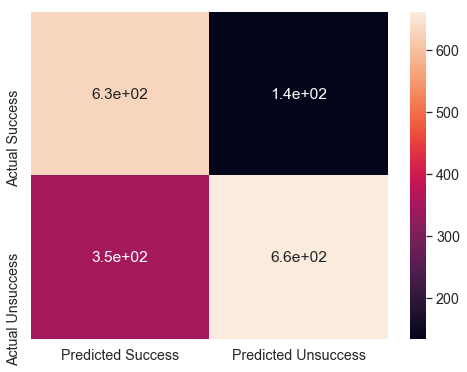

In [153]:
def Evaluationmatrix_DT(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_DT(y_test,predict_popular_DT)

print('R square value : ',r2_score(y_test, predict_popular_DT))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_popular_DT)
print(cm)
index = ['Predicted Success','Predicted Unsuccess']  
columns = ['Actual Success','Actual Unsuccess']  
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)

Mean Squared Error: 0.19140755484580252
Mean absolute Error: 0.30774797533732773
R square value :  0.21964026095014066
[[756  10]
 [915  95]]


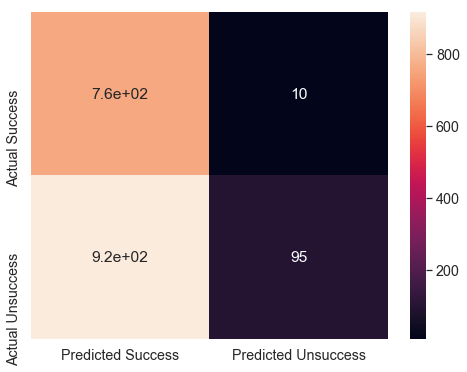

In [154]:
def Evaluationmatrix_RF(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_RF(y_test,predict_popular_RF)

print('R square value : ',r2_score(y_test, predict_popular_RF))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_popular_RF.astype("int64"))
print(cm)
index = ['Predicted Success','Predicted Unsuccess']  
columns = ['Actual Success','Actual Unsuccess']  
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)

Mean Squared Error: 0.35754504504504503
Mean absolute Error: 0.35754504504504503
R square value :  -0.45769459452472705
[[634 132]
 [503 507]]


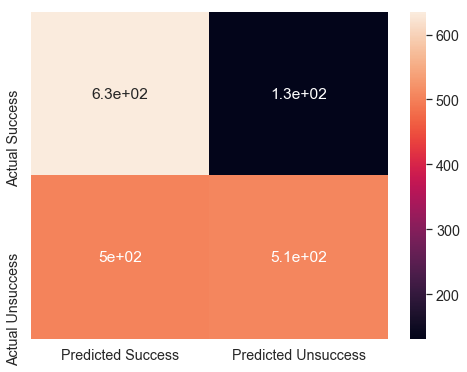

In [155]:
def Evaluationmatrix_LR(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_LR(y_test,predict_popular_LR)

print('R square value : ',r2_score(y_test, predict_popular_LR))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_popular_LR.astype("int64"))
print(cm)
index = ['Predicted Success','Predicted Unsuccess']  
columns = ['Actual Success','Actual Unsuccess']  
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)

Mean Squared Error: 0.3716216216216216
Mean absolute Error: 0.3716216216216216
R square value :  -0.5150841454902675
[[ 111  655]
 [   5 1005]]


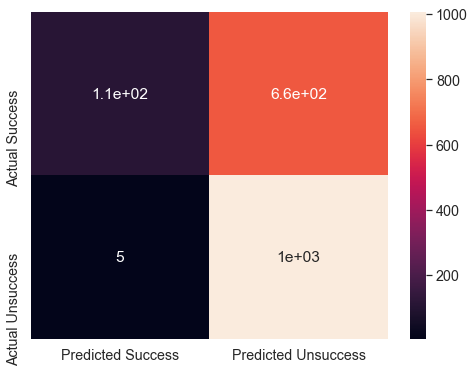

In [156]:
def Evaluationmatrix_NB(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_NB(y_test,predict_popular_NB)

print('R square value : ',r2_score(y_test, predict_popular_NB))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_popular_NB.astype("int64"))
print(cm)
index = ['Predicted Success','Predicted Unsuccess']  
columns = ['Actual Success','Actual Unsuccess']  
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)

Mean Squared Error: 0.28716216216216217
Mean absolute Error: 0.28716216216216217
R square value :  -0.17074683969702487
[[550 216]
 [294 716]]


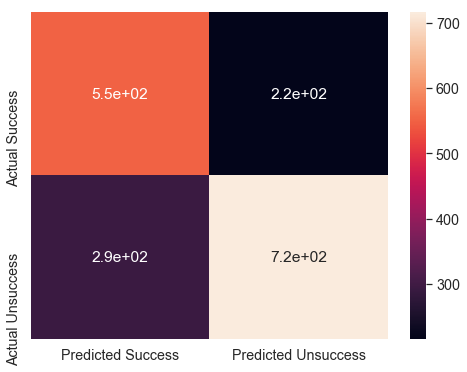

In [157]:
def Evaluationmatrix_KNN(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_KNN(y_test,predict_popular_KNN)

print('R square value : ',r2_score(y_test, predict_popular_KNN))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_popular_KNN.astype("int64"))
print(cm)
index = ['Predicted Success','Predicted Unsuccess']  
columns = ['Actual Success','Actual Unsuccess']  
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)

Mean Squared Error: 0.2877252252252252
Mean absolute Error: 0.2877252252252252
R square value :  -0.17304242173564655
[[546 220]
 [291 719]]


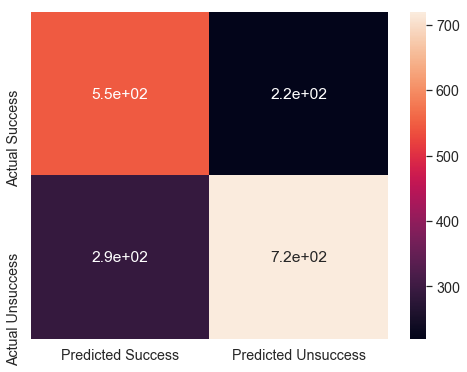

In [158]:
def Evaluationmatrix_ANN(y_test, y_pred):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_test,y_pred)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_test,y_pred)))

Evaluationmatrix_ANN(y_test,predict_popular_ANN)

print('R square value : ',r2_score(y_test, predict_popular_ANN))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_popular_ANN.astype("int64"))
print(cm)
index = ['Predicted Success','Predicted Unsuccess']  
columns = ['Actual Success','Actual Unsuccess']  
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)